In [1]:
import sys
import matplotlib.pyplot as plt

In [2]:
from typing import List
import torch.nn as nn
import torch
import datetime


# Hyperparameters (Put here for now. Probably should find a way to organize them)
SIZE = 256
INPUT_CHANNELS = 3
OUTPUT_CHANNELS = 3
NUM_EPOCHS = 10
BATCH_SIZE = 10
LEARNING_RATE = 1e-4
BETA1 = 0.5 # Beta1 hyperparam for Adam optimizers
SHUFFLE = True


class NeuralModel(nn.Module):
    def __init__(self):
        super().__init__()

        # Load in default parameters
        self.size = SIZE
        self.input_c = INPUT_CHANNELS
        self.output_c = OUTPUT_CHANNELS
        self.num_epochs = NUM_EPOCHS
        self.batch_size = BATCH_SIZE
        self.lr = LEARNING_RATE
        self.beta1 = BETA1
        self.shuffle = SHUFFLE

        current_time = datetime.datetime.now() - datetime.timedelta(hours=8)
        print("Starting at:", current_time.strftime("%H:%M:%S"))


    def forward(self, obs):
        raise NotImplementedError()

    def train(self):
        raise NotImplementedError()

    def prepare_batch(self, data):
        pass

In [3]:
import time
from typing import List
import functools
import torch.nn as nn
import torch
from torch.utils.data import DataLoader
from torch.utils import data
import h5py
import math
import numpy as np


# Hyperparameters
NUM_DOWNS = 8
NGF = 64
LAMBDA_L1 = 100

class Dataset(data.Dataset):
    def __init__(self, x, y=None):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        if self.y is None:
            return self.x[index]
        else:
            return self.x[index], self.y[index]


# Reference: https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/
class Pix2PixUnet(NeuralModel, nn.Module):
    """Create a Unet-based generator"""

    def __init__(self):
        """Construct a Unet generator
        Parameters:
            input_nc (int)  -- the number of channels in input images
            output_nc (int) -- the number of channels in output images
            num_downs (int) -- the number of downsamplings in UNet. For example, # if |num_downs| == 7,
                                image of size 128x128 will become of size 1x1 # at the bottleneck
            ngf (int)       -- the number of filters in the last conv layer
            norm_layer      -- normalization layer
        We construct the U-Net from the innermost layer to the outermost layer.
        It is a recursive process.
        """
        super().__init__()

        # hyper params
        self.num_downs = NUM_DOWNS
        self.ngf = NGF
        self.lambda_L1 = LAMBDA_L1
        self.norm_layer = nn.BatchNorm2d

        # construct unet structure
        unet_block = UnetSkipConnectionBlock(self.ngf * 8, self.ngf * 8, input_nc=None, submodule=None, norm_layer=self.norm_layer, innermost=True)  # add the innermost layer
        for i in range(self.num_downs - 5):          # add intermediate layers with ngf * 8 filters
            unet_block = UnetSkipConnectionBlock(self.ngf * 8, self.ngf * 8, input_nc=None, submodule=unet_block, norm_layer=self.norm_layer, use_dropout=False)
        # gradually reduce the number of filters from ngf * 8 to ngf
        unet_block = UnetSkipConnectionBlock(self.ngf * 4, self.ngf * 8, input_nc=None, submodule=unet_block, norm_layer=self.norm_layer)
        unet_block = UnetSkipConnectionBlock(self.ngf * 2, self.ngf * 4, input_nc=None, submodule=unet_block, norm_layer=self.norm_layer)
        unet_block = UnetSkipConnectionBlock(self.ngf, self.ngf * 2, input_nc=None, submodule=unet_block, norm_layer=self.norm_layer)
        self.model = UnetSkipConnectionBlock(self.output_c, self.ngf, input_nc=self.input_c, submodule=unet_block, outermost=True, norm_layer=self.norm_layer)  # add the outermost layer
        
        self.device = torch.device(
            f"cuda:0" if torch.cuda.is_available() else "cpu"
        )
        print(f"Device: {self.device}")
        self.model.to(self.device)
        
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr, betas=(self.beta1, 0.999))
        self.criterion = nn.BCEWithLogitsLoss()
        self.criterionL1 = torch.nn.L1Loss()

    def forward(self, x):
        return self.model(x)


    def train(self):
        # load data from file
        with h5py.File("../data_950_0to1.h5", 'r') as hf:
            data_x = hf['x'][:10]
            data_y = hf['y'][:10]

        # 80/20 split
        # data_tr, data_te = data_obs.split()
        train_ind = int(len(data_x) * 0.8)
        data_tr = Dataset(data_x[:train_ind], data_y[:train_ind])


        train_loader = DataLoader(
            data_tr,
            batch_size=self.batch_size,
            shuffle=self.shuffle
        )
        
        train_losses = []
        loss_gen_list = []
        loss_L1_list = []
        
        for epoch in range(self.num_epochs):
            start_time1 = time.time()

            epoch_loss = torch.tensor(0.0, device=self.device)

            for batch_idx, batch in enumerate(train_loader):
                start_time2 = time.time()

                data, target = batch

                outputs = self.model(data.float().to(self.device))
                
                # if you want to see the progress of the outputs
#                 if batch_idx % 20 == 0:
#                     out = outputs.detach().cpu().numpy()
#                     tar = target.detach().cpu().numpy()
#                     plt.subplot(1, 2, 1)
#                     plt.imshow(out.transpose((0, 2, 3, 1))[0])
#                     plt.subplot(1, 2, 2)
#                     plt.imshow(tar.transpose((0, 2, 3, 1))[0])
#                     plt.show()

                loss_gen = self.criterion(outputs, target.float().to(self.device))
                loss_L1 = self.criterionL1(outputs, target.float().to(self.device)) * self.lambda_L1
                loss = loss_gen + loss_L1
                
                loss_gen_list.append(loss_gen)
                loss_L1_list.append(loss_L1)
                
                # Aggregate loss across mini-batches (per epoch)
                epoch_loss += loss

                # Backprop and perform Adam optimisation
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                if batch_idx % 38 == 0:
                    print(
                    f"Epoch: {epoch}\tBatch: {batch_idx}\tGen Loss: {loss_gen:.5f}\tL1 Loss: {loss_L1:.5f}"
                    f"\tTotal Time: {(time.time() - start_time2)/60:.3f} minutes"
                    )

            print(
                f"Epoch: {epoch}\tTrain Loss: {epoch_loss/len(train_loader):.5f}"
                f"\tTotal Time: {(time.time() - start_time1)/60:.3f} minutes"
            )

            train_losses.append(epoch_loss / len(train_loader))
        
        fig, (ax1, ax2) = plt.subplots(2, figsize=(15,15))
        fig.suptitle("Loss Plots")
        ax1.plot(range(len(loss_gen_list)), loss_gen_list, alpha = 0.7)
        ax1.set_title("Gen Loss")
        ax2.plot(range(len(loss_gen_list)), loss_L1_list, alpha = 0.7)
        ax2.set_title("L1 Loss")
        plt.show()
        
        return train_losses
    
    
    def predict(self):
        # load data from file
        with h5py.File("../data_950_0to1.h5", 'r') as hf:
            data_x = hf['x'][:]
            data_y = hf['y'][:]
        
        color_distance = []
        
        # 80/20 split
        # data_tr, data_te = data_obs.split()
        train_ind = int(len(data_x) * 0.8)
        data_te = Dataset(data_x[train_ind:], data_y[train_ind:])
            
        test_loader = DataLoader(
            data_te,
            batch_size=self.batch_size,
            shuffle=self.shuffle
        )

        for batch_idx, batch in enumerate(test_loader):
            start_time2 = time.time()

            data, target = batch
            x = data.detach().cpu().numpy().transpose((0, 2, 3, 1))[0]
            y = target.detach().cpu().numpy().transpose((0, 2, 3, 1))[0]
            
            outputs = self.model(data.float().to(self.device))
            
            y_hat = outputs.detach().cpu().numpy().transpose((0, 2, 3, 1))[0]
            
            dist = 0
            for i in range(0, len(y)):
                for j in range(0,len(y[i])):
                    dist += math.sqrt((y[i][j][0] + y_hat[i][j][0])**2 + (y[i][j][1] + y_hat[i][j][1])**2 +
                                      (y[i][j][2] + y_hat[i][j][2])**2)
            dist = dist/len(y)
            color_distance.append(dist)

            if batch_idx < 30:
                fig, ax = plt.subplots(1, 3, figsize=(16, 5))
                ax[0].axis('off')
                ax[0].set_title('$X$')
                ax[0].imshow(x)
                ax[1].axis('off')
                ax[1].set_title('$\hat{Y}$')
                ax[1].imshow(y_hat)
                ax[2].axis('off')
                ax[2].set_title('$Y$')
                ax[2].imshow(y)   
                plt.show()
                print("Color difference: %d" % (dist))
                
        print("Average color difference: %d" % (np.mean(np.array(color_distance))))
        print("Max color difference: %d" % (max(color_distance)))
        print("Min color difference: %d" % (min(color_distance)))
        
        print(color_distance)


class UnetSkipConnectionBlock(nn.Module):
    """Defines the Unet submodule with skip connection.
        X -------------------identity----------------------
        |-- downsampling -- |submodule| -- upsampling --|
    """

    def __init__(self, outer_nc, inner_nc, input_nc=None,
                 submodule=None, outermost=False, innermost=False, norm_layer=nn.BatchNorm2d, use_dropout=False):
        """Construct a Unet submodule with skip connections.
        Parameters:
            outer_nc (int) -- the number of filters in the outer conv layer
            inner_nc (int) -- the number of filters in the inner conv layer
            input_nc (int) -- the number of channels in input images/features
            submodule (UnetSkipConnectionBlock) -- previously defined submodules
            outermost (bool)    -- if this module is the outermost module
            innermost (bool)    -- if this module is the innermost module
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers.
        """
        super(UnetSkipConnectionBlock, self).__init__()
        self.outermost = outermost
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d
        if input_nc is None:
            input_nc = outer_nc
        downconv = nn.Conv2d(input_nc, inner_nc, kernel_size=4,
                             stride=2, padding=1, bias=use_bias)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = norm_layer(inner_nc)
        uprelu = nn.ReLU(True)
        upnorm = norm_layer(outer_nc)

        if outermost:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(inner_nc, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=use_bias)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=use_bias)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]

            if use_dropout:
                model = down + [submodule] + up + [nn.Dropout(0.5)]
            else:
                model = down + [submodule] + up

        self.model = nn.Sequential(*model)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:   # add skip connections
            return torch.cat([x, self.model(x)], 1)

Starting at: 17:54:50
Device: cpu
Epoch: 0	Batch: 0	Gen Loss: 0.76627	L1 Loss: 50.79465	Total Time: 0.072 minutes
Epoch: 0	Train Loss: 51.56092	Total Time: 0.072 minutes
Epoch: 1	Batch: 0	Gen Loss: 0.73653	L1 Loss: 41.20973	Total Time: 0.073 minutes
Epoch: 1	Train Loss: 41.94627	Total Time: 0.073 minutes
Epoch: 2	Batch: 0	Gen Loss: 0.72188	L1 Loss: 34.47138	Total Time: 0.073 minutes
Epoch: 2	Train Loss: 35.19326	Total Time: 0.074 minutes
Epoch: 3	Batch: 0	Gen Loss: 0.71887	L1 Loss: 29.37531	Total Time: 0.073 minutes
Epoch: 3	Train Loss: 30.09418	Total Time: 0.073 minutes
Epoch: 4	Batch: 0	Gen Loss: 0.71816	L1 Loss: 25.56962	Total Time: 0.074 minutes
Epoch: 4	Train Loss: 26.28778	Total Time: 0.074 minutes
Epoch: 5	Batch: 0	Gen Loss: 0.71761	L1 Loss: 22.79946	Total Time: 0.076 minutes
Epoch: 5	Train Loss: 23.51706	Total Time: 0.076 minutes
Epoch: 6	Batch: 0	Gen Loss: 0.71673	L1 Loss: 20.83097	Total Time: 0.075 minutes
Epoch: 6	Train Loss: 21.54770	Total Time: 0.075 minutes
Epoch: 7	Batch

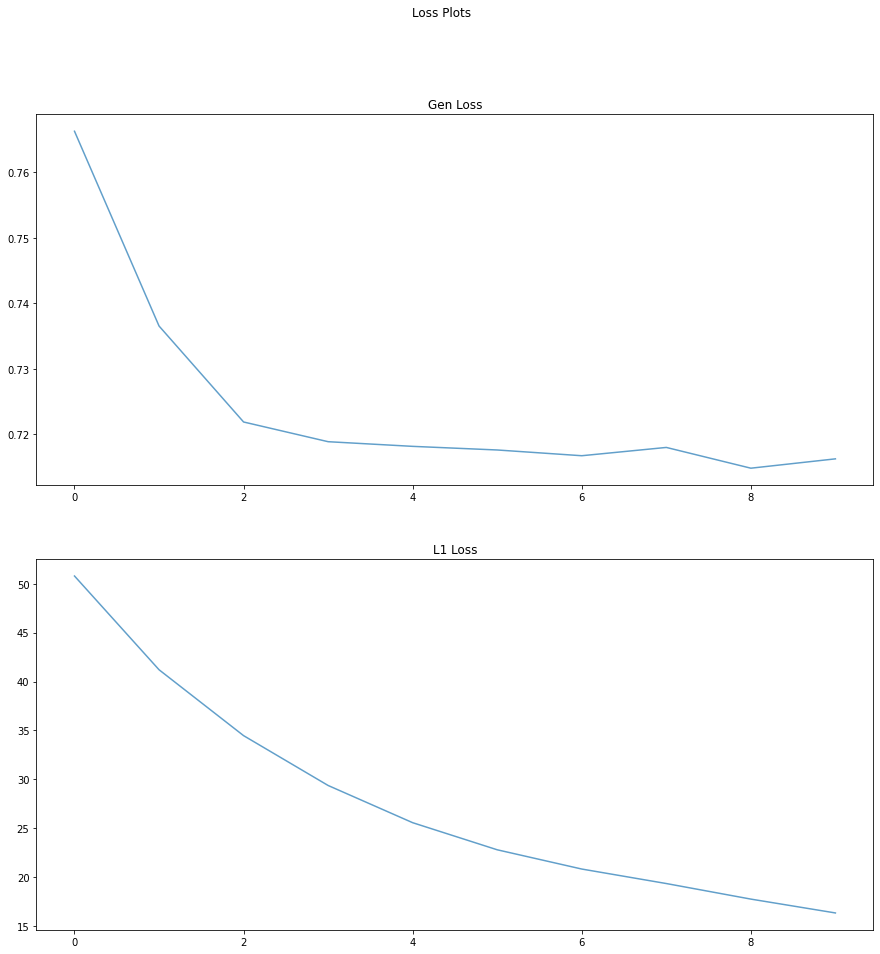

In [4]:
model = Pix2PixUnet()

tr_losses = model.train()

In [5]:
tr_losses

[tensor(51.5609, grad_fn=<DivBackward0>),
 tensor(41.9463, grad_fn=<DivBackward0>),
 tensor(35.1933, grad_fn=<DivBackward0>),
 tensor(30.0942, grad_fn=<DivBackward0>),
 tensor(26.2878, grad_fn=<DivBackward0>),
 tensor(23.5171, grad_fn=<DivBackward0>),
 tensor(21.5477, grad_fn=<DivBackward0>),
 tensor(20.0664, grad_fn=<DivBackward0>),
 tensor(18.4720, grad_fn=<DivBackward0>),
 tensor(17.0571, grad_fn=<DivBackward0>)]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


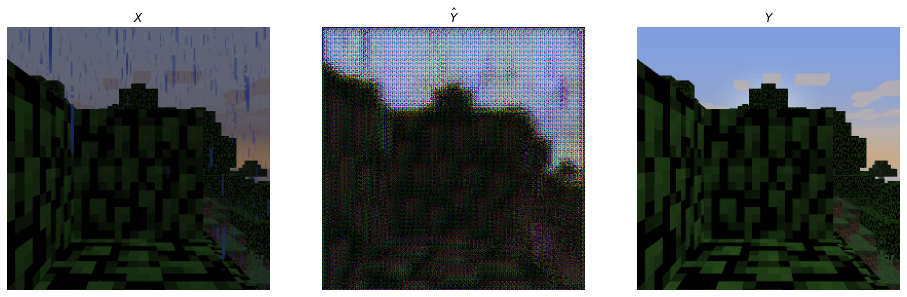

Color difference: 225


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


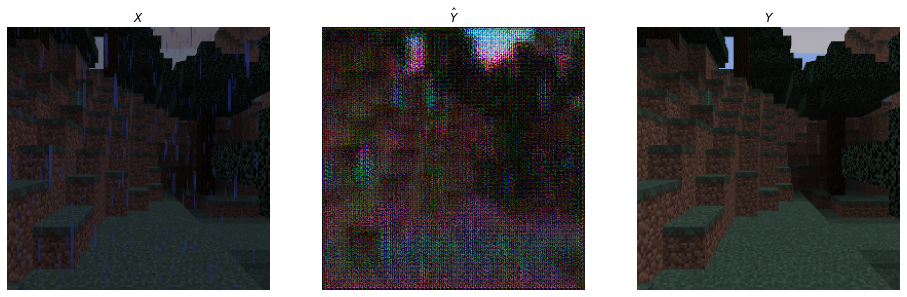

Color difference: 144


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


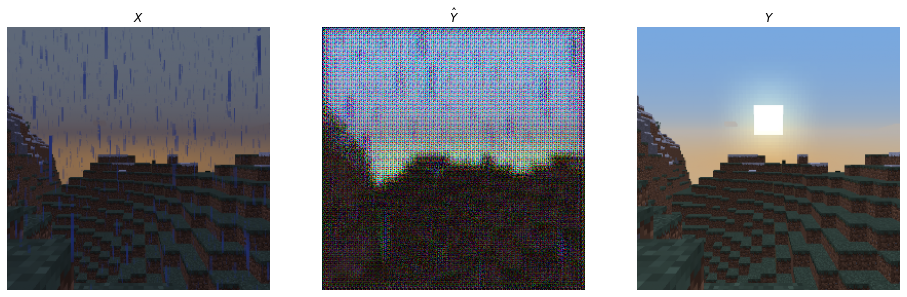

Color difference: 356


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


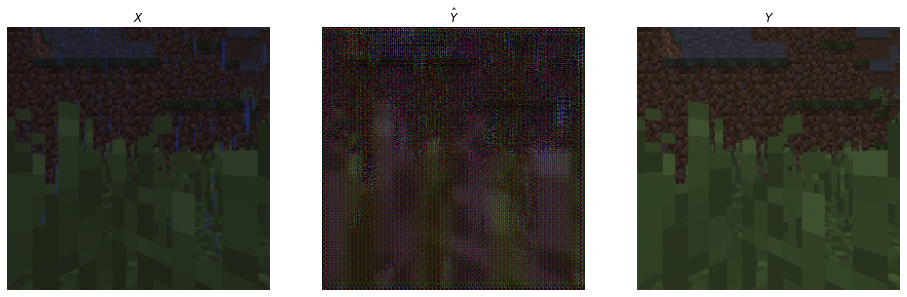

Color difference: 141


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


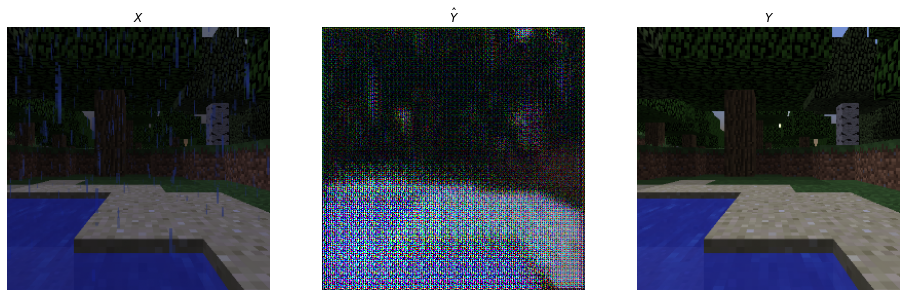

Color difference: 212


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


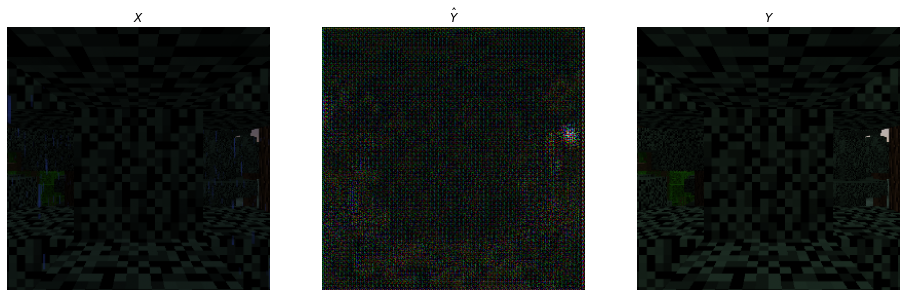

Color difference: 65


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


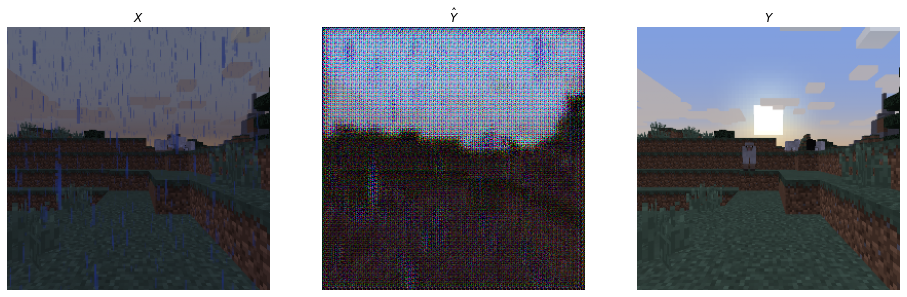

Color difference: 318


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


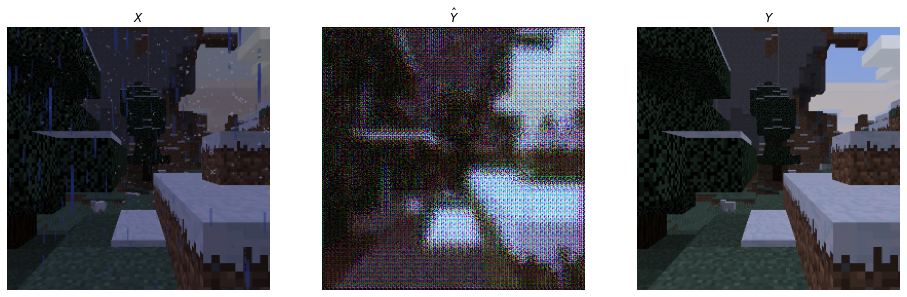

Color difference: 240


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


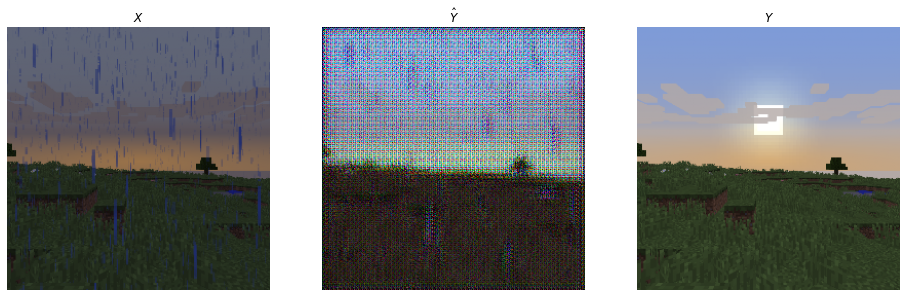

Color difference: 373


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


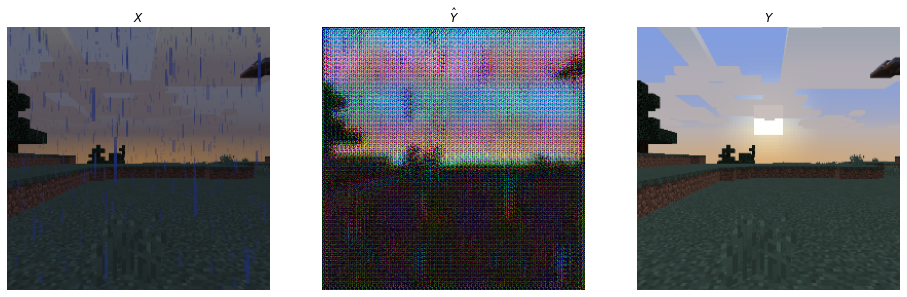

Color difference: 329


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


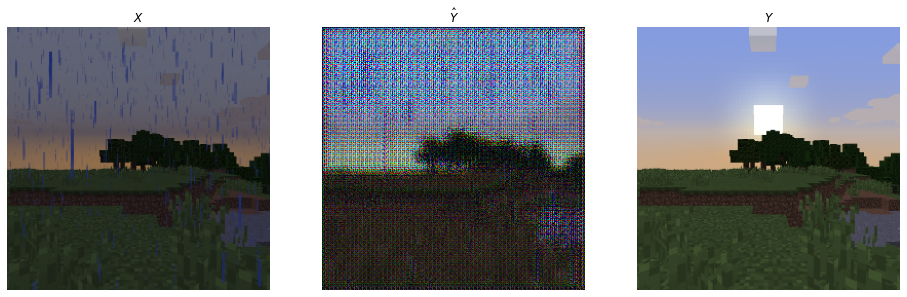

Color difference: 332


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


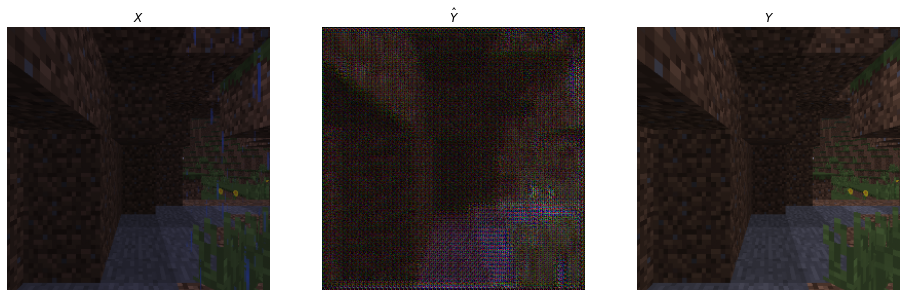

Color difference: 120


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


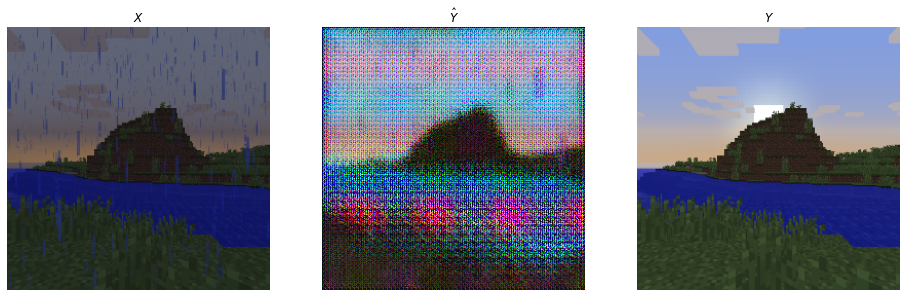

Color difference: 393


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


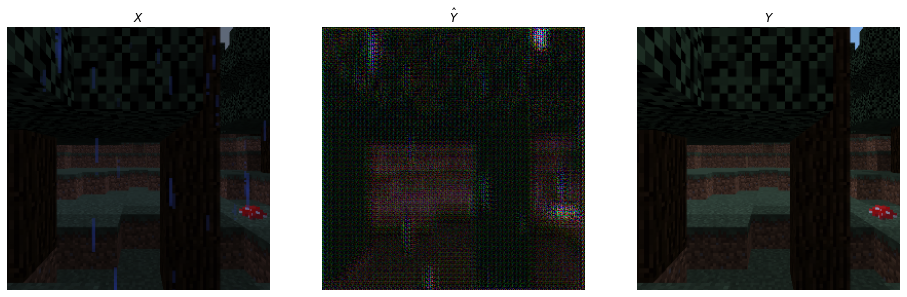

Color difference: 73


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


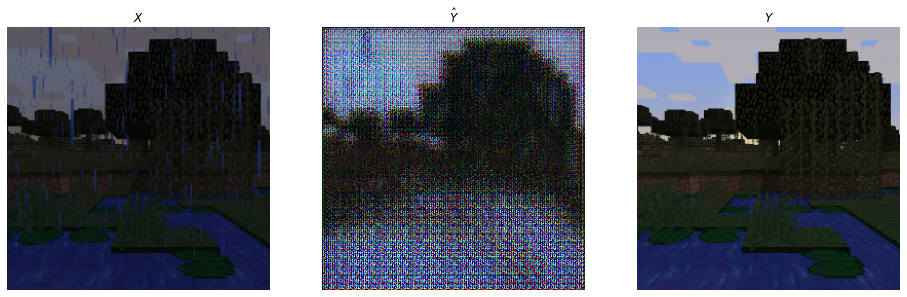

Color difference: 264


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


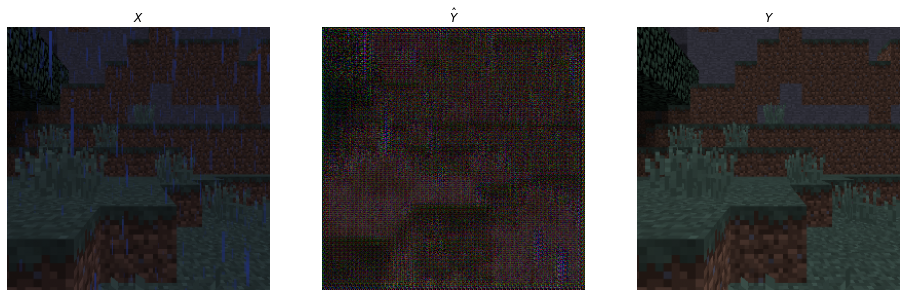

Color difference: 133


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


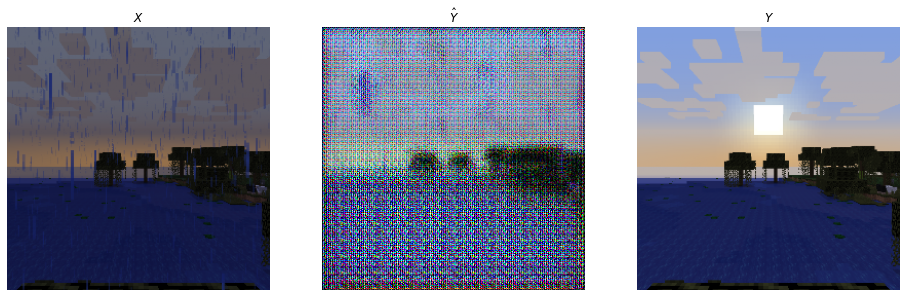

Color difference: 451


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


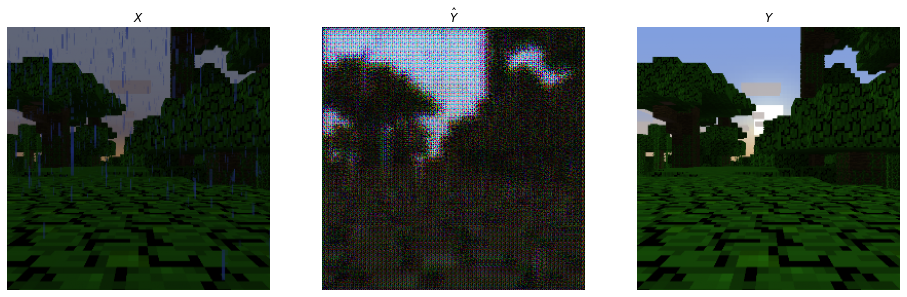

Color difference: 171


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


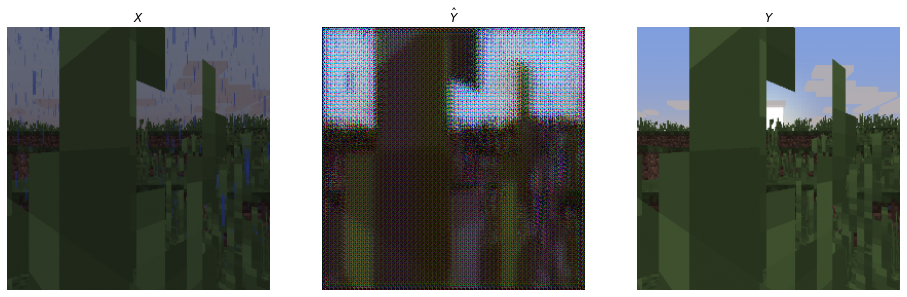

Color difference: 250
Average color difference: 242
Max color difference: 451
Min color difference: 65
[225.3818170930655, 144.58281878510053, 356.8845322399451, 141.44938120212294, 212.0121174017519, 65.71293069839594, 318.3452759201633, 240.27828069496945, 373.3613533383479, 329.8767023269447, 332.9250841689179, 120.18442695673394, 393.787303277551, 73.5404834538251, 264.77642140933807, 133.16412259523582, 451.18460468839044, 171.69939457116797, 250.44603454567178]


In [6]:
model.predict()  # graphs first 30

In [7]:
# plt.imshow(data_x3.transpose((0, 2, 3, 1))[0])
# plt.show()